## Model Evaluating, Part 3

- Measure a model's relevance, with using precision, recall, and the F1-score
- Reading a confusion matrix
- Optimizing the precision and recall of a classification model 
- Plotting a receiver operating characteristic (ROC curve)

In [9]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder

# Assign features to NumPy array X
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

# Transform class labels into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Divide the dataset
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])


//anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


#### Reading a confusion matrix

- Confusion Matrix; A matrix that lays out the performance of a learning algorithm. Square matrix that reports the counts of the true positive, true negative, false positive, false negative predictions of a classifier. 

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

pipe_svc.fit(X_train, y_train)

y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


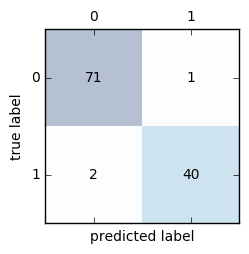

In [15]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

---

- The **error (ERR)** can be understood as the sum of all **false predictions** divided by the number of **total predictions**

$$ERR = \frac{FP + FN}{FP + FN + TP + TN}$$

- The **accuracy (ACC)** is calculated as the sum of **correct predictions** divided by the **total number of predictions.** 

$$ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR$$

- **True Positive Rate (TPR)** and **false positive rate (FPR)** are performance metrics taht are especially usefll for iambalanced class problems.

$$FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$

$$TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

- **Precision (PRE)** and **recall (REC)** are performance metrics that are related to those true positive and true negative rates.

$$PRE = \frac{TP}{TP + FP}$$

$$REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

- In practice, often a combination of precision and recall is used, this is called the **F1-score**

$$F1 = 2 * \frac{PRE * REC}{PRE + REC}$$

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))


Precision: 0.976


In [17]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [18]:
print('F1 score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1 score: 0.964


---

#### Plotting a reciever operating characteristic (ROC)

- Selecting models for classification based on their performance with respect to the FP and TP rates.
- The diagonal of an ROC graph can be interpreted as random guessing, and classification models that fall below the diagonol are considered as worse than random guessing. 
- A perfect classifier would fall into the top-left corner
- **area under the curve (AUC)** - based on the ROC curve, charcterize the performance

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
import numpy as np 
from scipy import interp
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), 
                    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])

X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state = 1)

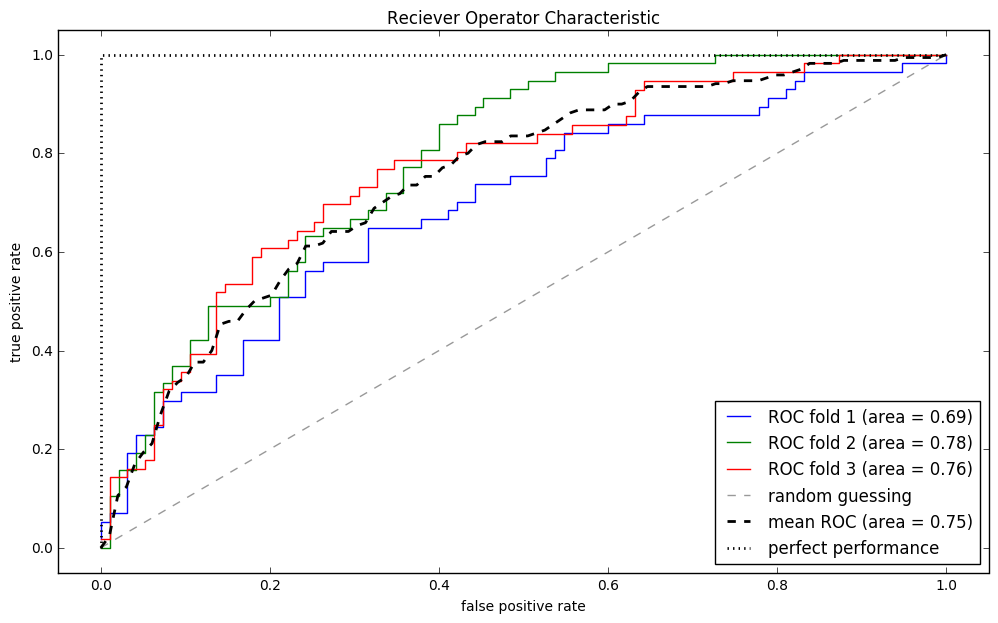

In [31]:
fig = plt.figure(figsize = (12,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % ( i+1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Reciever Operator Characteristic')
plt.legend(loc = 'lower right')
plt.show()

#### ROC AUC score only

In [33]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))

ROC AUC: 0.662


In [34]:
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

Accuracy: 0.711
